<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

07:55:31 Starting...
07:55:31 Installing yfinance into Google notebook...
07:55:36 Installing arch into Google notebook...
07:55:45 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [130]:
nprint("Fetching data from Yahoo!...")
data=download(ticker:='^GSPC','1990-01-02','2019-12-31',auto_adjust=True,progress=False)
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred

nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=data['Return'].mean()))

data['Direction']=data['Return'].apply(lambda x: one if x>foffset else -one if x<foffset else zero)

for lag in range(1,forder+1):
    data['Return_'+str(lag)]=data['Return'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

data.dropna(inplace=True)
display(data)

09:03:08 Fetching data from Yahoo!...
09:03:08 Creating filter rule indicators with order 3 and offset 0.035043.


<ipython-input-130-928172831da1>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


^GSPC,Close,High,Low,Open,Volume,Return,Direction,Return_1,Direction_1,Return_2,...,Return_3,Direction_3,Filter_000,Filter_001,Filter_010,Filter_011,Filter_100,Filter_101,Filter_110,Filter_111
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.451447,1.0,-0.975624,-1.0,-0.861299,...,-0.258554,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-1.178669,-1.0,0.451447,1.0,-0.975624,...,-0.861299,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1990-01-10,347.309998,349.619995,344.320007,349.619995,175990000,-0.660717,-1.0,-1.178669,-1.0,0.451447,...,-0.975624,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1990-01-11,348.529999,350.140015,347.309998,347.309998,154390000,0.351272,1.0,-0.660717,-1.0,-1.178669,...,0.451447,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-01-12,339.929993,348.529999,339.489990,348.529999,183880000,-2.467508,-1.0,0.351272,1.0,-0.660717,...,-1.178669,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,3224.010010,3227.780029,3222.300049,3226.050049,3064530000,0.086614,1.0,0.494478,1.0,0.445929,...,-0.043230,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-12-24,3223.379883,3226.429932,3220.510010,3225.449951,1296530000,-0.019545,-1.0,0.086614,1.0,0.494478,...,0.445929,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-12-26,3239.909912,3240.080078,3227.199951,3227.199951,2164540000,0.512817,1.0,-0.019545,-1.0,0.086614,...,0.494478,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Fit baseline GJR-GARCH model

In [131]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=0)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary())

09:03:13                                AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.000
Mean Model:                                    AR   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -9579.05
Distribution:      Generalized Error Distribution   AIC:                           19168.1
Method:                        Maximum Likelihood   BIC:                           19202.8
                                                    No. Observations:                 7554
Date:                            Mon, Feb 03 2025   Df Residuals:                     7553
Time:                                    09:03:13   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------

09:03:42 Fitting GJR-GARCH model with filter rules...
09:03:43                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -9567.21
Distribution:      Generalized Error Distribution   AIC:                           19160.4
Method:                        Maximum Likelihood   BIC:                           19250.5
                                                    No. Observations:                 7554
Date:                            Mon, Feb 03 2025   Df Residuals:                     7545
Time:                                    09:03:42   Df Model:                            9
                                   Mean Model                                  
                  coef    std err     

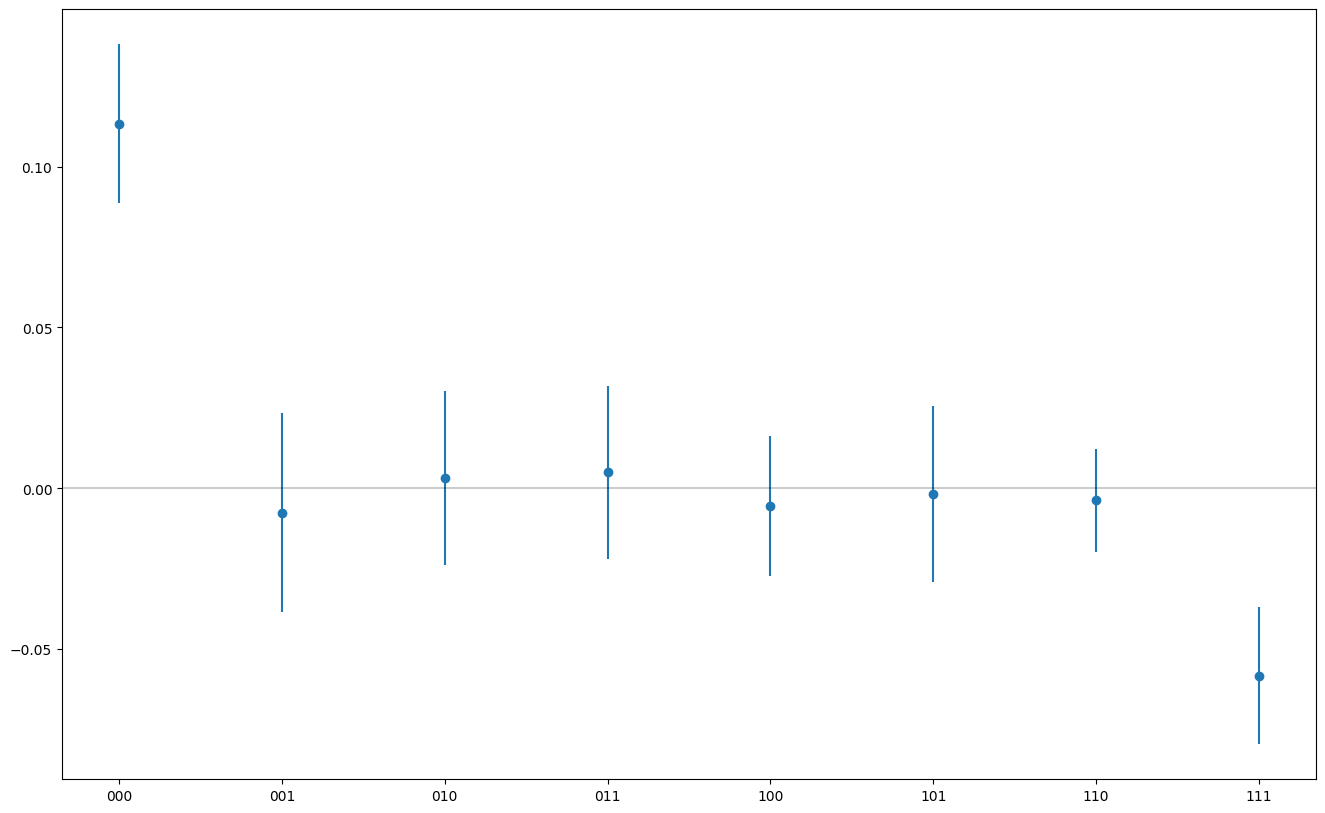

In [133]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX(data['Return'],data[fcols:=data.columns[data.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary())
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=list(map(lambda l:l.replace('Filter_',''),coefficients.index)),y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o')
plot.axhline(color='black',alpha=0.2)